In [1]:
from tensorflow.keras.applications import vgg16
from tensorflow import keras
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Sequential
from tensorflow.python.framework import ops
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np
from tensorflow import keras
import sys
import cv2
from tensorflow.keras.models import load_model
import json
import dlib
from PIL import Image
tf.compat.v1.disable_eager_execution()

from keras.models import load_model
import os
import sys
import pandas as pd
from PIL import Image
import numpy as np
sys.path.insert(1, '../src')

import preprocess_image
import importlib
importlib.reload(preprocess_image)

import matplotlib.pyplot as plt


In [4]:
mapping

{'Black': 0,
 'East Asian': 1,
 'Indian': 2,
 'Latino_Hispanic': 3,
 'Middle Eastern': 4,
 'Southeast Asian': 5,
 'White': 6}

In [2]:
def detect_face(image_path, im_size = 224, default_max_size=800,size = 300, padding = 0.25):
    cnn_face_detector = dlib.cnn_face_detection_model_v1('./dlib_mod/mmod_human_face_detector.dat')
    sp = dlib.shape_predictor('./dlib_mod/shape_predictor_5_face_landmarks.dat')
    base = 2000  # largest width and height

    img = dlib.load_rgb_image(image_path)
    old_height, old_width, _ = img.shape
    old_height, old_width, _ = img.shape

    if old_width > old_height:
        new_width, new_height = default_max_size, int(default_max_size * old_height / old_width)
    else:
        new_width, new_height =  int(default_max_size * old_width / old_height), default_max_size
    img = dlib.resize_image(img, rows=new_height, cols=new_width)
    dets = cnn_face_detector(img, 1)
    num_faces = len(dets)
    if num_faces == 0:
        print("Sorry, there were no faces found in '{}'".format(image_path))
        return
    elif num_faces > 1:
        print("Multiple face in '{}'. A random face will be returned".format(image_path))
    faces = dlib.full_object_detections()
    for detection in dets:
        rect = detection.rect
        faces.append(sp(img, rect))
    image = dlib.get_face_chips(img, faces, size=size, padding = padding)[0]

    image = Image.fromarray(image, 'RGB')
    image = image.resize((im_size, im_size))

    #image = np.array(image) / 255.0
    #ori_img = np.array(image)
    processed_img = resnet_v2.preprocess_input(np.array(image))
    processed_img = processed_img[None,:]
    return processed_img

def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = resnet_v2.preprocess_input(x)
    #x = detect_face(img_path)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_7'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = load_model(save_path)
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #if K.image_dim_ordering() == 'th':
    #    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def grad_cam(input_model, input_biased_model, image, category_index, biased_category_index, layer_name):
    model = input_model
    biased_model = input_biased_model
    #model = Sequential()
    #model.add(input_model)

    nb_classes = 7
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    biased_target_layer = lambda x: target_category_loss(x, biased_category_index, nb_classes)
    
    model.add(Lambda(target_layer,
                     output_shape = target_category_loss_output_shape))
    
    biased_model.add(Lambda(biased_target_layer,
                     output_shape = target_category_loss_output_shape))

    loss = K.sum(model.layers[-1].output)
    #print("loss: ", loss)
    biased_loss = K.sum(biased_model.layers[-1].output)
    
    #conv_output =  [l for l in model.layers[0].layers if l.name is layer_name][0].output
    conv_output =  [l for l in model.layers if l.name == layer_name][0].output
    #print("conv_output: ", conv_output)
    biased_conv_output =  [l for l in biased_model.layers if l.name == layer_name][0].output
    
    
    grads = normalize(K.gradients(loss, conv_output)[0])
    biased_grads = normalize(K.gradients(biased_loss, biased_conv_output)[0])
    
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])
    biased_gradient_function = K.function([biased_model.layers[0].input], [biased_conv_output, biased_grads])
    

    output, grads_val = gradient_function([image])
    biased_output, biased_grads_val = biased_gradient_function([image])
    
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    biased_output, biased_grads_val = biased_output[0, :], biased_grads_val[0, :, :, :]
    

    weights = np.mean(grads_val, axis = (0, 1))
    biased_weights = np.mean(biased_grads_val, axis = (0, 1))
    
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)
    biased_cam = np.ones(biased_output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    for i, w in enumerate(biased_weights):
        biased_cam += w * biased_output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    biased_cam = cv2.resize(biased_cam, (224, 224))
    #print("cam1: ", cam)
    cam = np.maximum(cam, 0)
    biased_cam = np.maximum(biased_cam, 0)
    #print("cam2: ", cam)

    max_arr = np.concatenate([cam,biased_cam])
#     return np.max(cam)
    max_norm = np.max(max_arr)
#     print("cam_max: ", np.max(cam))
#     print("b_cam max: ", np.max(biased_cam))
#     return max_norm
#     heatmap = cam / np.max(cam)
    heatmap = cam / max_norm
    #biased_heatmap = biased_cam/ np.max(biased_cam)
    biased_heatmap = biased_cam/ max_norm
    
    #print("heat: ", heatmap)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    biased_cam = cv2.applyColorMap(np.uint8(255*biased_heatmap), cv2.COLORMAP_JET)
    
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    biased_heatmap = cv2.applyColorMap(np.uint8(255*biased_heatmap), cv2.COLORMAP_JET)
    
    cam = np.float32(cam / 255) + np.float32(image)
    biased_cam = np.float32(biased_cam / 255) + np.float32(image)
    #heatmap = np.float32(cam / 255)
    
    cam = 255 * cam / np.max(cam)
    biased_cam = 255 * biased_cam / np.max(biased_cam)
    #heatmap = 255 * heatmap / np.max(heatmap)
    
    return np.uint8(cam), np.uint8(biased_cam), heatmap, biased_heatmap, image
    #return cam, heatmap, image

### NOTE

If you want to input your own image(i.e. images that are not from the FairFace), please uncomment the last line in load_image function and comment out the rest(except the first line)

* After you run the code below, it will generate two images: one for grad-cam and one for guided grad-cam. 

In [1]:
#generate grad-cam and guided backprop with unbiased and biased models
def generate_grad_cam():
    with open("./config/parameters.json") as f:
        data = json.load(f)
    f.close()

    model_param = data["model_param"]
    lr, epochs, batch_size, mapping_path, save_path, log_path, biased_save_path = model_param.values()

    with open(mapping_path) as f:
        mapping = json.load(f)
    f.close()
    
    print(;)
    grad_params = data["grad_cam"]
    race_model = load_model(save_path)
    biased_race_model = load_model(biased_save_path)
    
    #grad_cam
    img_num = grad_params["img_idx"]
    sample_img_path = grad_params["image_path"] + str(img_num) + ".jpg"
    
    preprocessed_input = load_image(sample_img_path)
    predictions = race_model.predict(preprocessed_input)
    biased_preds = biased_race_model.predict(preprocessed_input)

    predicted_class = np.argmax(predictions)
    biased_class = np.argmax(biased_preds)
    
    
    cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, biased_race_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
    cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
    cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)
    
    
    #guided_backprop
#     register_gradient()
#     guided_model = modify_backprop(race_model, 'GuidedBackProp')
#     biased_guided_model = modify_backprop(biased_race_model, 'GuidedBackProp')
    
#     saliency_fn = compile_saliency_function(guided_model)
#     biased_saliency_fn = compile_saliency_function(biased_guided_model)
    
#     saliency = saliency_fn([preprocessed_input, 0])
#     biased_saliency = biased_saliency_fn([preprocessed_input, 0])
    
#     gradcam = saliency[0] * heatmap[..., np.newaxis]
#     biased_gradcam = biased_saliency[0] * biased_heatmap[..., np.newaxis]
    
#     cv2.imwrite("GUIDED_GRADCAM_" + str(img_num) + ".jpg", deprocess_image(gradcam))
#     cv2.imwrite("BIASED_GUIDED_GRADCAM_" + str(img_num) + ".jpg", deprocess_image(biased_gradcam))
    
    
    #cv2.imwrite("guided_gradcam_7.jpg", deprocess_image(gradcam))
    

    
    
    

In [63]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

In [3]:
race_dict = {
        6: 'White', 
        0: 'Black', 
        1: 'East Asian', 
        2: 'Indian', 
        4: 'Middle Eastern',
        3: 'Latino_Hispanic',
        5: 'Southeast Asian'
}

In [4]:
val_df = pd.read_csv("../../a01capstonegroup03/fairface_label_val.csv")
val_df.head()

file    age  gender             race  service_test
0  val/1.jpg    3-9    Male       East Asian         False
1  val/2.jpg  50-59  Female       East Asian          True
2  val/3.jpg  30-39    Male            White          True
3  val/4.jpg  20-29  Female  Latino_Hispanic          True
4  val/5.jpg  20-29    Male  Southeast Asian         False

In [6]:
val_df[val_df["race"] == "Indian"].sample(15)

file    age  gender    race  service_test
409    val/410.jpg  30-39    Male  Indian         False
3136  val/3137.jpg  40-49    Male  Indian          True
4987  val/4988.jpg  30-39    Male  Indian         False
6886  val/6887.jpg  30-39  Female  Indian          True
9478  val/9479.jpg  40-49    Male  Indian          True
7568  val/7569.jpg  30-39    Male  Indian          True
4082  val/4083.jpg  30-39    Male  Indian          True
9877  val/9878.jpg  10-19  Female  Indian          True
3244  val/3245.jpg  60-69    Male  Indian         False
8481  val/8482.jpg  50-59    Male  Indian         False
9964  val/9965.jpg  30-39  Female  Indian          True
6711  val/6712.jpg  30-39  Female  Indian          True
7434  val/7435.jpg  50-59    Male  Indian          True
3830  val/3831.jpg    3-9  Female  Indian          True
9743  val/9744.jpg  30-39  Female  Indian         False

In [23]:
val_df[val_df["race"] == "Middle Eastern"].sample(15)

file           age  gender            race  service_test
2624  val/2625.jpg         40-49    Male  Middle Eastern          True
9080  val/9081.jpg         20-29    Male  Middle Eastern          True
7300  val/7301.jpg         30-39  Female  Middle Eastern          True
4124  val/4125.jpg  more than 70  Female  Middle Eastern          True
2254  val/2255.jpg           3-9    Male  Middle Eastern         False
2295  val/2296.jpg         40-49    Male  Middle Eastern          True
5822  val/5823.jpg         40-49    Male  Middle Eastern          True
8292  val/8293.jpg  more than 70    Male  Middle Eastern         False
9158  val/9159.jpg         20-29    Male  Middle Eastern          True
652    val/653.jpg         30-39    Male  Middle Eastern          True
6367  val/6368.jpg         60-69    Male  Middle Eastern         False
7974  val/7975.jpg         30-39    Male  Middle Eastern         False
3156  val/3157.jpg         30-39    Male  Middle Eastern         False
7722  val/7723.jpg         10-19  Female  Middle Eastern          True
9748  val/9749.jpg         20-29  Female  Middle Eastern          True

In [72]:
val_df[val_df["race"] == "Latino_Hispanic"].sample(15)

file    age  gender             race  service_test
2258  val/2259.jpg  20-29  Female  Latino_Hispanic          True
549    val/550.jpg  50-59  Female  Latino_Hispanic          True
3565  val/3566.jpg  20-29    Male  Latino_Hispanic         False
2287  val/2288.jpg  20-29  Female  Latino_Hispanic         False
3263  val/3264.jpg  20-29  Female  Latino_Hispanic         False
7084  val/7085.jpg  40-49    Male  Latino_Hispanic         False
1230  val/1231.jpg  40-49    Male  Latino_Hispanic         False
7353  val/7354.jpg  30-39  Female  Latino_Hispanic          True
7712  val/7713.jpg  50-59    Male  Latino_Hispanic         False
5800  val/5801.jpg  60-69  Female  Latino_Hispanic          True
3887  val/3888.jpg  20-29    Male  Latino_Hispanic          True
5467  val/5468.jpg  30-39    Male  Latino_Hispanic         False
8181  val/8182.jpg  30-39  Female  Latino_Hispanic          True
2717  val/2718.jpg  30-39    Male  Latino_Hispanic          True
1681  val/1682.jpg  20-29  Female  Latino_Hispanic          True

In [22]:
val_df[val_df["race"] == "Southeast Asian"].sample(15)

file           age  gender             race  service_test
2849    val/2850.jpg         10-19    Male  Southeast Asian         False
3860    val/3861.jpg         10-19  Female  Southeast Asian          True
2126    val/2127.jpg         10-19    Male  Southeast Asian         False
6666    val/6667.jpg         40-49    Male  Southeast Asian         False
6328    val/6329.jpg         30-39    Male  Southeast Asian         False
6165    val/6166.jpg         40-49  Female  Southeast Asian          True
5440    val/5441.jpg         20-29  Female  Southeast Asian         False
2606    val/2607.jpg  more than 70    Male  Southeast Asian         False
4348    val/4349.jpg         40-49    Male  Southeast Asian          True
6286    val/6287.jpg         10-19  Female  Southeast Asian         False
10578  val/10579.jpg         10-19  Female  Southeast Asian          True
973      val/974.jpg         20-29  Female  Southeast Asian          True
4083    val/4084.jpg         20-29    Male  Southeast Asian          True
6981    val/6982.jpg         20-29    Male  Southeast Asian          True
5784    val/5785.jpg         50-59    Male  Southeast Asian         False

In [25]:
val_df[val_df["race"] == "Black"].sample(15)

file    age  gender   race  service_test
8346    val/8347.jpg  40-49  Female  Black          True
7563    val/7564.jpg  40-49  Female  Black         False
4442    val/4443.jpg    3-9    Male  Black          True
5807    val/5808.jpg  30-39  Female  Black          True
3157    val/3158.jpg    3-9  Female  Black          True
8722    val/8723.jpg  10-19  Female  Black         False
8170    val/8171.jpg  50-59    Male  Black         False
5053    val/5054.jpg  20-29    Male  Black         False
5630    val/5631.jpg  20-29    Male  Black          True
913      val/914.jpg  20-29  Female  Black          True
10075  val/10076.jpg  20-29  Female  Black         False
9113    val/9114.jpg  20-29  Female  Black         False
2683    val/2684.jpg  20-29    Male  Black          True
10527  val/10528.jpg    3-9    Male  Black          True
7225    val/7226.jpg    3-9  Female  Black         False

In [26]:
val_df[val_df["race"] == "White"].sample(15)

file    age  gender   race  service_test
5562    val/5563.jpg  50-59    Male  White         False
8465    val/8466.jpg  30-39  Female  White         False
6861    val/6862.jpg    3-9    Male  White          True
4842    val/4843.jpg  10-19  Female  White         False
4157    val/4158.jpg  50-59    Male  White         False
5213    val/5214.jpg  30-39    Male  White         False
8474    val/8475.jpg    3-9  Female  White          True
4688    val/4689.jpg  20-29  Female  White         False
10021  val/10022.jpg  20-29  Female  White         False
67        val/68.jpg    3-9  Female  White          True
9786    val/9787.jpg  30-39  Female  White         False
8557    val/8558.jpg  50-59    Male  White          True
4317    val/4318.jpg  20-29  Female  White         False
9149    val/9150.jpg  10-19    Male  White         False
3051    val/3052.jpg  20-29    Male  White          True

## **Compare biased vs unbiased grad-cam for minority groups in biased dataset**

### Race: Indian

**EXAMPLE 1**

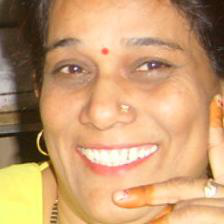

In [66]:
img_num = 97
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [67]:
#RACE GRAD-CAM
# race_biased_model = load_model("../models/race_biased_v1.hdf5")
# race_model = load_model("../models/race_v6.hdf5") 

preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [28]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Indian
Prediction with BIASED model:  Latino_Hispanic


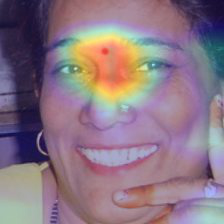

In [10]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

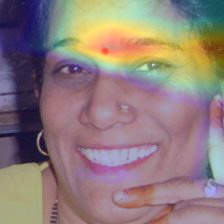

In [11]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#with both normalization

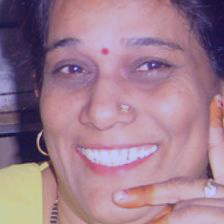

In [68]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

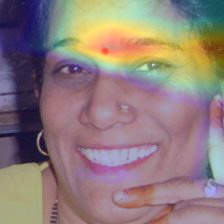

In [69]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

**True label: Indian**

In [29]:
val_df[val_df['file'] == "val/" + str(img_num) + ".jpg"]

file    age  gender    race  service_test
96  val/97.jpg  50-59  Female  Indian          True

**EXAMPLE 2**

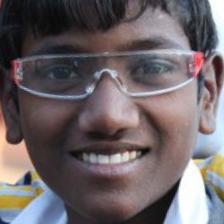

In [62]:
img_num = 274
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

**True label: Indian**

In [31]:
val_df[val_df['file'] == "val/" + str(img_num) + ".jpg"]

file    age gender    race  service_test
273  val/274.jpg  10-19   Male  Indian          True

In [63]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [33]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Indian
Prediction with BIASED model:  Latino_Hispanic


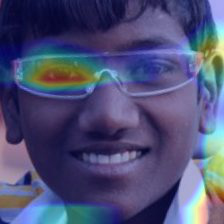

In [34]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

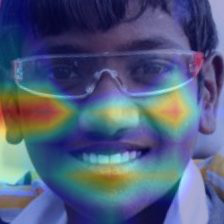

In [35]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#with both normalization

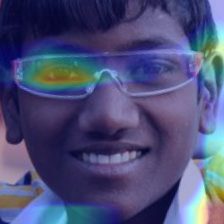

In [64]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

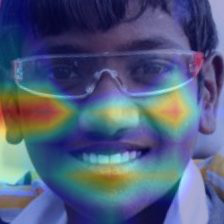

In [65]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

**EXAMPLE 3**

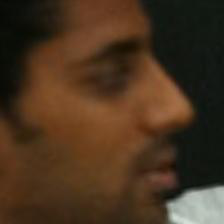

In [55]:
img_num = 6965
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [56]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [57]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Indian
Prediction with BIASED model:  Latino_Hispanic


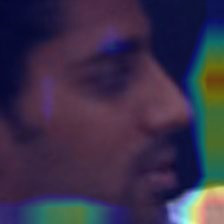

In [39]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

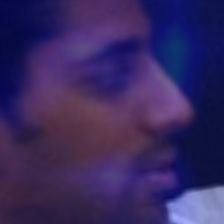

In [40]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#with both (unbiased and biased) normalization

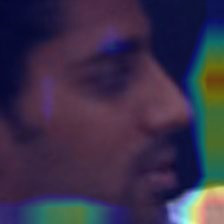

In [58]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

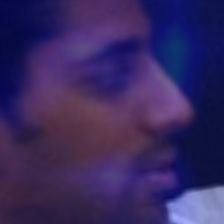

In [59]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

**EXAMPLE 4**

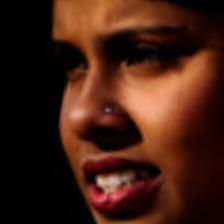

In [42]:
img_num = 978
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [52]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [ ]:
#with normalization of biased map

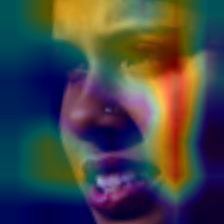

In [44]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

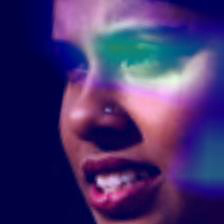

In [45]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#without normalization

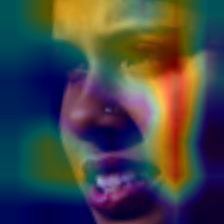

In [48]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

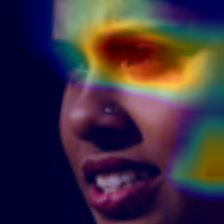

In [49]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#with normalization of max unbiased and biased map

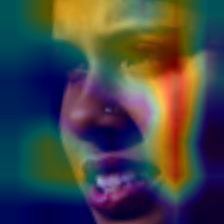

In [53]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

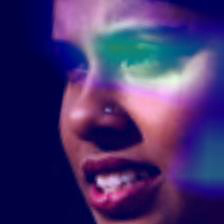

In [54]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

**EXAMPLE 5**

In [69]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

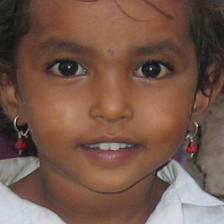

In [70]:
img_num = 3831
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [71]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [72]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Indian
Prediction with BIASED model:  Latino_Hispanic


In [ ]:
#NO NORMALZATION

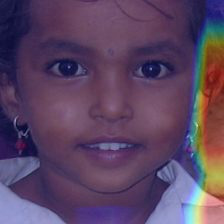

In [21]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

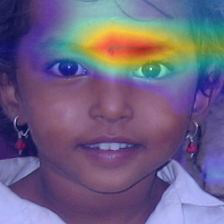

In [22]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#with only biased normalized

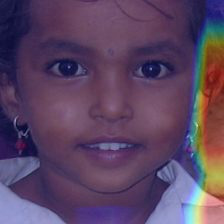

In [73]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

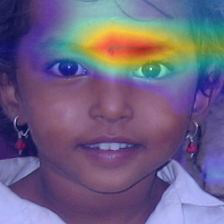

In [74]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [75]:
#WITH BOTH normalization

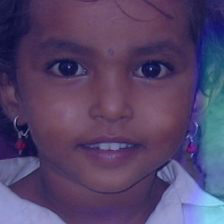

In [27]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

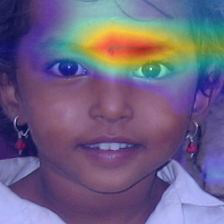

In [28]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

**EXAMPLE 6**

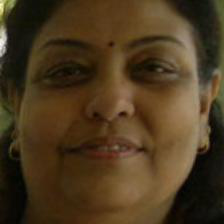

In [31]:
img_num = 6712
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [46]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [47]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Indian
Prediction with BIASED model:  Latino_Hispanic


In [ ]:
#both normalization

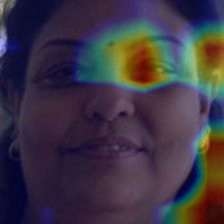

In [43]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

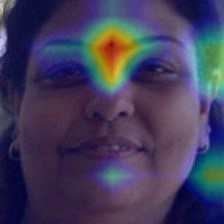

In [44]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#only biased normalized

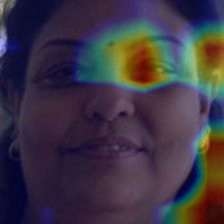

In [38]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

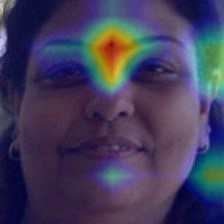

In [39]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#no norm

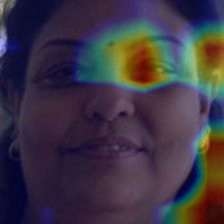

In [48]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

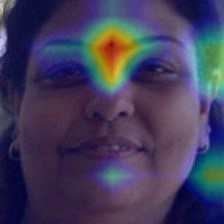

In [49]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

### Race: Middle Eastern

In [76]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

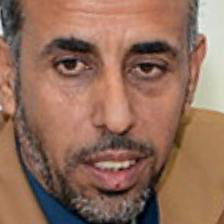

In [77]:
img_num = 2625
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [78]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [79]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Middle Eastern
Prediction with BIASED model:  Latino_Hispanic


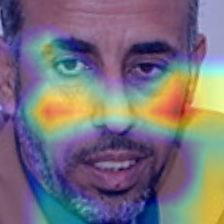

In [80]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

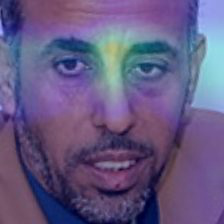

In [81]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 2

In [15]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

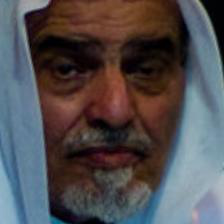

In [16]:
img_num = 6368
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [17]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [19]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Middle Eastern
Prediction with BIASED model:  White


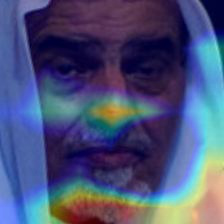

In [20]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

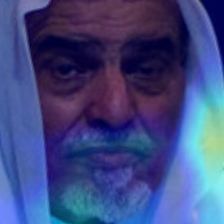

In [21]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 3

In [22]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

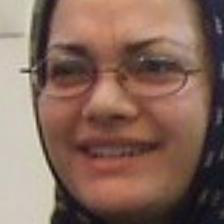

In [24]:
img_num = 7301
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [25]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [27]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Latino_Hispanic
Prediction with BIASED model:  Latino_Hispanic


In [ ]:
#both normalizations

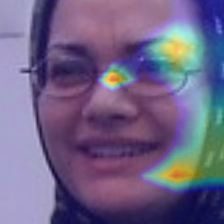

In [103]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

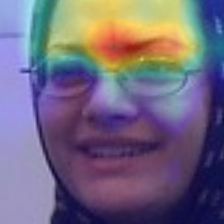

In [102]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#no norm

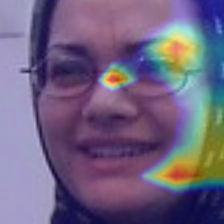

In [109]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

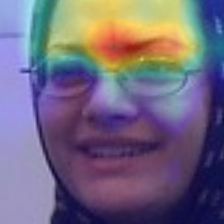

In [110]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#training set needs to include more middle Eastern women with a specific feature such as the
#head scarf as a key feature for model to focus on

### Race: Latino_Hispanic

In [ ]:
#Example 1

In [35]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

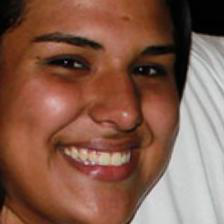

In [42]:
img_num = 9485
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [43]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [44]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Indian
Prediction with BIASED model:  Latino_Hispanic


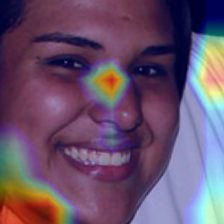

In [45]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

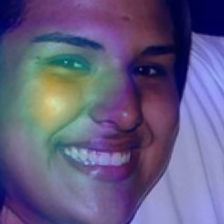

In [46]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 2

In [48]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

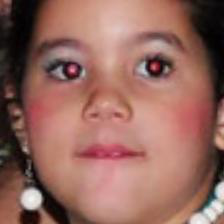

In [67]:
img_num = 10473
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [68]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [69]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Latino_Hispanic
Prediction with BIASED model:  Latino_Hispanic


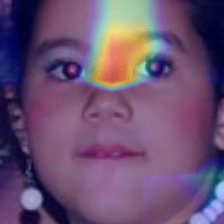

In [70]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

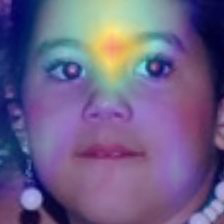

In [71]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 3

In [91]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

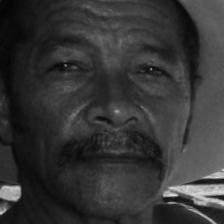

In [92]:
img_num = 1231
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [93]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [80]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Southeast Asian
Prediction with BIASED model:  Black


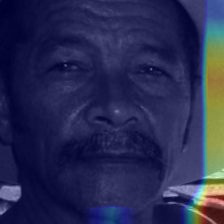

In [79]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

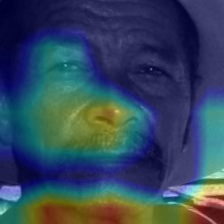

In [81]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#only biased norm

In [94]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Southeast Asian
Prediction with BIASED model:  Black


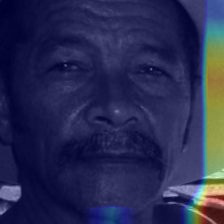

In [95]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

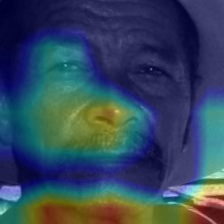

In [96]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

### Race: Southeast Asian

In [109]:
#Example 1

In [99]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

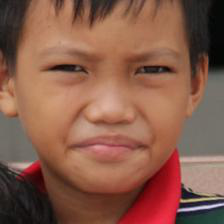

In [104]:
img_num = 9624
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [105]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [106]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Southeast Asian
Prediction with BIASED model:  Latino_Hispanic


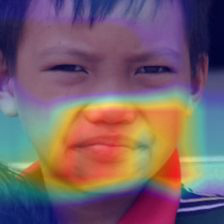

In [107]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

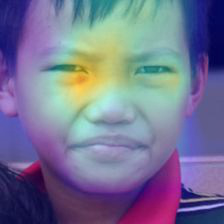

In [108]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 2

In [8]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


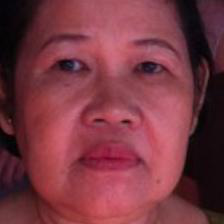

In [9]:
img_num = 3219
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [10]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [11]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Southeast Asian
Prediction with BIASED model:  Southeast Asian


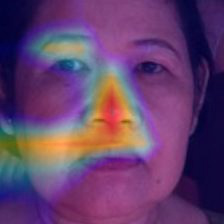

In [12]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

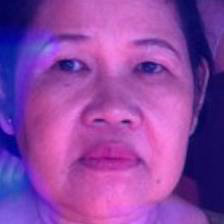

In [13]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 3

In [5]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


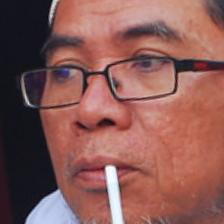

In [6]:
img_num = 10926
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [7]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [8]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Southeast Asian
Prediction with BIASED model:  Southeast Asian


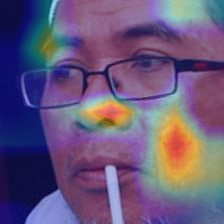

In [9]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

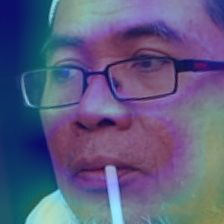

In [10]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 4

In [11]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

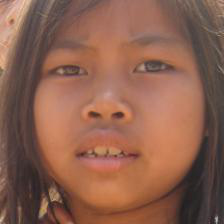

In [16]:
img_num = 7467
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [17]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [18]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Southeast Asian
Prediction with BIASED model:  Southeast Asian


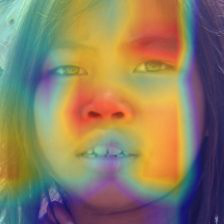

In [19]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

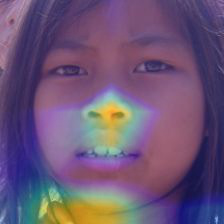

In [20]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 5

In [41]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

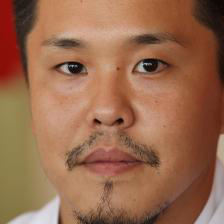

In [42]:
# img_num = 6287
img_num = 6329
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [43]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

True

In [44]:
print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  East Asian
Prediction with BIASED model:  Southeast Asian


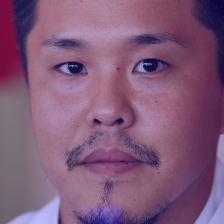

In [45]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

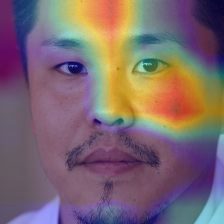

In [46]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

### Race: Black

In [ ]:
#Example 1

In [47]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

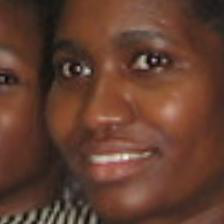

In [48]:
img_num = 8347
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [49]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

Prediction with FAIR model:  Black
Prediction with BIASED model:  Black


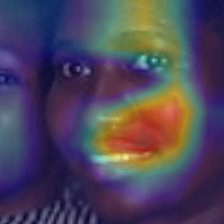

In [50]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

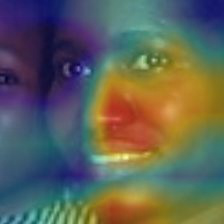

In [51]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Example 2

In [ ]:
race_biased_model = load_model("../models/race_biased_v1.hdf5")
race_model = load_model("../models/race_v6.hdf5") 

In [ ]:
img_num = 4443
img_path = os.path.join("../../a01capstonegroup03/fairface_pad025/", "val/" + str(img_num) + ".jpg")
image_open = Image.open(img_path)
image_open

In [ ]:
preprocessed_input = load_image(img_path)
predictions = race_model.predict(preprocessed_input)
biased_preds = race_biased_model.predict(preprocessed_input)

predicted_class = np.argmax(predictions)
biased_class = np.argmax(biased_preds)

cam, biased_cam, heatmap, biased_heatmap, img = grad_cam(race_model, race_biased_model, preprocessed_input, predicted_class, biased_class, "conv2d_7")
cv2.imwrite("GRADCAM_" + str(img_num) + ".jpg", cam)
cv2.imwrite("BIASED_GRADCAM_" + str(img_num) + ".jpg", biased_cam)

print("Prediction with FAIR model: ", race_dict[predicted_class])
print("Prediction with BIASED model: ", race_dict[biased_class])

In [ ]:
image_open = Image.open("GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
image_open = Image.open("BIASED_GRADCAM_" + str(img_num) + ".jpg")
image_open

In [ ]:
#Average Heatmaps

In [21]:
val_df = pd.read_csv("../../a01capstonegroup03/fairface_label_val.csv")
val_df.head()

file    age  gender             race  service_test
0  val/1.jpg    3-9    Male       East Asian         False
1  val/2.jpg  50-59  Female       East Asian          True
2  val/3.jpg  30-39    Male            White          True
3  val/4.jpg  20-29  Female  Latino_Hispanic          True
4  val/5.jpg  20-29    Male  Southeast Asian         False

In [25]:
val_df[val_df['file'] == "val/" + str(img_num) + ".jpg"]

file  age gender             race  service_test
139  val/140.jpg  3-9   Male  Southeast Asian         False

In [104]:
val_df[val_df["race"] == "Indian"][:15]

file    age  gender    race  service_test
12    val/13.jpg  40-49  Female  Indian          True
13    val/14.jpg  20-29    Male  Indian          True
30    val/31.jpg    3-9  Female  Indian          True
31    val/32.jpg  40-49  Female  Indian         False
39    val/40.jpg  50-59  Female  Indian         False
41    val/42.jpg  20-29  Female  Indian         False
69    val/70.jpg  20-29    Male  Indian          True
73    val/74.jpg  30-39  Female  Indian         False
75    val/76.jpg  20-29    Male  Indian          True
90    val/91.jpg  10-19  Female  Indian          True
92    val/93.jpg  20-29  Female  Indian          True
96    val/97.jpg  50-59  Female  Indian          True
103  val/104.jpg  10-19    Male  Indian          True
108  val/109.jpg    3-9    Male  Indian          True
109  val/110.jpg  30-39    Male  Indian          True

In [11]:
val_df['race'].value_counts()

White              2085
Latino_Hispanic    1623
Black              1556
East Asian         1550
Indian             1516
Southeast Asian    1415
Middle Eastern     1209
Name: race, dtype: int64

In [15]:
def race_prediction(preprocessed_input):
    pred2 = race_model.predict(preprocessed_input)[0]
    race_dict = {
        6: 'White', 
        0: 'Black', 
        1: 'East Asian', 
        2: 'Indian', 
        4: 'Middle Eastern',
        3: 'Latino_Hispanic',
        5: 'Southeast Asian'
    }
    max_ind = list(pred2).index(max(pred2))
    return race_dict[max_ind]

In [11]:
#generate average heatmap for a specific race
from tqdm import tqdm
def generate_avg_heatmap(race, val_df):
    race_val_df = val_df[val_df["race"] == race][:20]
    heatmaps = []
    for row in tqdm(race_val_df.iterrows()):
        img_file = row[1]["file"]
        img_path = "../../a01capstonegroup03/fairface_pad025/" + img_file
        
#         orig = cv2.imread(img_path)
        #print(img_path)
        #resized = cv2.resize(orig, (224, 224))
        
        preprocessed_input = load_image(img_path)
        predictions = race_model.predict(preprocessed_input)
        predicted_class = np.argmax(predictions[0])
        
        cam, heatmap, img = grad_cam(race_model, preprocessed_input, predicted_class, "conv2d_7")
        #cv2.imwrite("gradcam_1234.jpg", cam)
#         cam = GradCAM(race_model, predicted_class)
#         heatmap = cam.compute_heatmap(img_face)
        
#         resized = cv2.resize(orig, (198, 198))
#         heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
#         (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
    
        heatmaps.append(heatmap)
        
    
    arr= np.zeros((224,224, 3),np.float)
    N = len(heatmaps)
    for im in heatmaps:
        imarr=np.array(im,dtype=np.float)
#         print(arr.shape)
#         print(imarr.shape)
        
        arr=arr+imarr/N

    # Round values in array and cast as 8-bit integer
    arr=np.array(np.round(arr),dtype=np.uint8)
    cv2.imwrite("race20_"+ race + "_heatmap.jpg", arr)
        

In [10]:
generate_avg_heatmap("White", val_df) #100 

100it [35:23, 21.24s/it]


In [13]:
generate_avg_heatmap("Black", val_df)

50it [44:44, 53.70s/it]


In [12]:
generate_avg_heatmap("Indian", val_df)

20it [02:27,  7.36s/it]
